In [1]:
import pandas as pd
import tensorflow.python.distribute.distribute_lib

df_train_unshuffled = pd.read_csv('train/train.csv')
df_val_unshuffled = pd.read_csv('train/test.csv')

df_train = df_train_unshuffled.sample(frac=1, random_state=42).reset_index(drop=True)
df_val = df_val_unshuffled.sample(frac=1, random_state=42).reset_index(drop=True)

In [2]:
from keras_preprocessing.image import ImageDataGenerator

augmentation_generator = ImageDataGenerator(rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

train_dataset = augmentation_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='Filename',
    y_col='Label',
    subset='training',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=(150,150)
)

val_dataset = augmentation_generator.flow_from_dataframe(
    dataframe=df_val,
    x_col='Filename',
    y_col='Label',
    subset='validation',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=(150,150)
)

Found 5055 validated image filenames belonging to 4 classes.
Found 154 validated image filenames belonging to 4 classes.


In [4]:
from keras.src.models import Sequential
import keras.src.layers as layers

data_augmentation = Sequential([
        layers.RandomRotation(factor = (-.25, .3), fill_mode = 'reflect', interpolation = 'bilinear', seed = 42),
        layers.RandomBrightness(factor = (-.45, .45), value_range = (0.0, 1.0), seed = 42),
        layers.RandomContrast(factor = (.5), seed = 42),
        # layers.RandomFlip("horizontal_and_vertical")
    ])

In [5]:
import keras.src.layers as layers
from keras import regularizers
from keras import initializers
strategy = tensorflow.distribute.get_strategy()

with strategy.scope():
    model = Sequential([
        data_augmentation,

        # one input - 16 filters - 7x7 kernel
        layers.Conv2D(filters=16, kernel_size=(7, 7), input_shape=(150, 150, 3),
                      strides=(2, 2), activation='relu', padding='valid', kernel_regularizer=regularizers.L2(0.0005),
                      kernel_initializer=initializers.HeUniform),

        # 32 filters - 3x3 kernel
        layers.Conv2D(filters=32, kernel_size=(3, 3),
                      activation='relu', padding='same', kernel_regularizer=regularizers.L2(0.0005)),
        layers.BatchNormalization(),
        layers.Conv2D(filters=32, kernel_size=(3, 3), 
                      strides=(2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.L2(0.0005)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(strides=(2, 2), pool_size=(2, 2), padding='same'),
        layers.Dropout(0.25),

        # 64 filters
        layers.Conv2D(filters=64, kernel_size=(3, 3),
                      activation='relu', padding='same', kernel_regularizer=regularizers.L2(0.0005)),
        layers.BatchNormalization(),
        layers.Conv2D(filters=64, kernel_size=(3, 3),
                      strides=(2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.L2(0.0005)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(strides=(2, 2), pool_size=(2, 2), padding='same'),
        layers.Dropout(0.25),

        # 128 filters
        layers.Conv2D(filters=128, kernel_size=(3, 3),
                      activation='relu', padding='same', kernel_regularizer=regularizers.L2(0.0005)),
        layers.BatchNormalization(),
        layers.Conv2D(filters=128, kernel_size=(3, 3),
                      strides=(2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.L2(0.0005)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(strides=(2, 2), pool_size=(2, 2), padding='same'),
        layers.Dropout(0.25),

        # flattening
        layers.Flatten(),

        # fully connected
        layers.Dense(units=256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # one output - 4 neurons and classes
        layers.Dense(units=4, activation='softmax')
    ])


C:\Users\KB\PycharmProjects\MachineLearnTest\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.compile(optimizer='RMSprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
import tensorflow.python.keras.callbacks as tf_callbacks
import keras.src.callbacks as keras_callbacks
import keras.src.saving

callbacks = [
    # callbacks.EarlyStopping(monitor = 'val_accuracy', 
    #                        patience = 30, 
    #                        mode = 'max', 
    #                        restore_best_weights = True, 
    #                        verbose=1),
    keras_callbacks.ModelCheckpoint(filepath='test.keras', 
                             monitor = 'val_accuracy', 
                             save_best_only = True, 
                             mode='max',
                             verbose=1)
]

# model = keras.src.saving.load_model('current.keras')

history = model.fit(
    train_dataset,
    callbacks=callbacks,
    # steps_per_epoch=train_dataset.samples//train_dataset.batch_size,
    # validation_steps=val_dataset.samples//val_dataset.batch_size,
    epochs=400,
    validation_data=val_dataset
)

C:\Users\KB\PycharmProjects\MachineLearnTest\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/400
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.5214 - loss: 1.6344
Epoch 1: val_accuracy improved from -inf to 0.46104, saving model to test.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 47s 277ms/step - accuracy: 0.5220 - loss: 1.6326 - val_accuracy: 0.4610 - val_loss: 1.4675
Epoch 2/400
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7218 - loss: 0.9870
Epoch 2: val_accuracy improved from 0.46104 to 0.50649, saving model to test.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 61s 383ms/step - accuracy: 0.7219 - loss: 0.9867 - val_accuracy: 0.5065 - val_loss: 1.4513
Epoch 3/400
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.7698 - loss: 0.8242
Epoch 3: val_accuracy improved from 0.50649 to 0.70130, saving model to test.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 43s 273ms/step - accuracy: 0.7697 - loss: 0.8243 - val_accuracy: 0.7013 - val_loss: 1.0506
Epoch 4/400
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7920 - loss: 0.7625
Epoch 4: val_accuracy did not improve 

Found 771 validated image filenames belonging to 4 classes.


C:\Users\KB\PycharmProjects\MachineLearnTest\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.8900 - loss: 0.3876
test accuracy:  0.91015625
test loss:  0.3512464463710785
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step


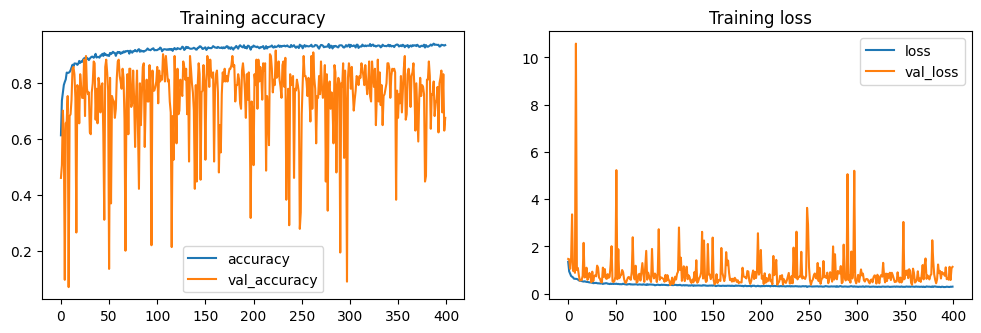

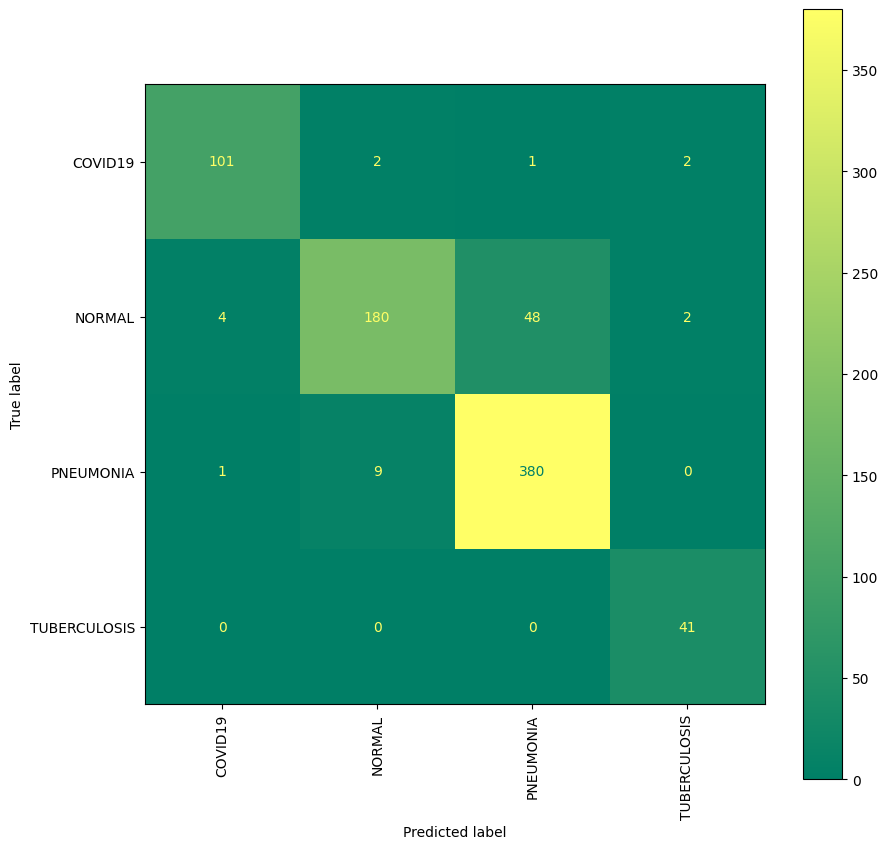

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 72, 72, 16)     │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 36, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 18, 18, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 2, 2, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,282,062 (4.89 MB)

 Trainable params: 426,884 (1.63 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 853,770 (3.26 MB)

In [8]:
from matplotlib import pyplot as plt
import keras
import keras.src.saving

plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training accuracy')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training loss')
plt.legend()

test_datagen = ImageDataGenerator(rescale=1./255)
df_test = pd.read_csv('train/test.csv')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='Filename',
    y_col='Label',
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=(150,150)
)

model = keras.src.saving.load_model('test.keras')

test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples//test_generator.batch_size)
print("test accuracy: ", test_acc)
print("test loss: ", test_loss)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# confusion matrix

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']

prediction_raw = model.predict(test_generator)
prediction_actual = np.argmax(prediction_raw, axis=1)
cm = confusion_matrix(np.array(test_generator.labels), prediction_actual)

con = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10, 10))
con = con.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

plt.show()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
model.summary()

In [70]:
model.save('current.keras')